In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV

## Weather, Road vs Accidents

In [ ]:
merged_all = pd.read_csv("/Users/annaywj/Desktop/SDSU/BDA600/Capstone/merged_all_variables.csv")

exclude_cols = ["CASE_ID", "COLLISION_DATE", "COLLISION_TIME", "Street_Name", "ROAD"]
merged_clean = merged_all.drop(columns=[col for col in exclude_cols if col in merged_all.columns], errors="ignore")

merged_encoded = pd.get_dummies(merged_clean, drop_first=True)
correlation_matrix = merged_encoded.corr()

top_corr_total = correlation_matrix["TOTAL_CRASHES"].drop("TOTAL_CRASHES", errors="ignore").sort_values(key=abs, ascending=False).head(10)
top_corr_severity = correlation_matrix["AVG_SEVERITY"].drop("AVG_SEVERITY", errors="ignore").sort_values(key=abs, ascending=False).head(10)

In [157]:
top_corr_severity

TOTAL_CRASHES                    0.339919
Speed_2022_MPH                  -0.336058
Lanes                            0.215610
COMMON_SURFACE_B                -0.180195
2022_AADT_Range_5,000-9,999      0.166530
2022_AADT_Range_10,000-19,999   -0.110571
2022_AADT_Range_20,000-39,999   -0.083287
1_year_Speed_%_change            0.077551
Speed_Limit_MPH                  0.070725
cloudcover                      -0.070284
Name: AVG_SEVERITY, dtype: float64

In [158]:
top_corr_total

ACCIDENT_YEAR                   -0.440201
Speed_2022_MPH                  -0.372929
AVG_SEVERITY                     0.339919
2022_AADT_Range_5,000-9,999      0.184069
2022_AADT_Range_10,000-19,999   -0.134924
2022_AADT_Range_20,000-39,999   -0.101949
cloudcover                      -0.096116
1_year_Speed_%_change            0.063606
Lanes                            0.050784
COMMON_SURFACE_B                -0.044405
Name: TOTAL_CRASHES, dtype: float64

In [ ]:
df = merged_all.copy()
aadt_order = [
    "<1,000", "1,000-4,999", "5,000-9,999", "10,000-19,999", "20,000-39,999",
    "40,000-64,999", "65,000-99,999", "100,000+"
]
df["AADT_Category"] = df["2022_AADT_Range"].astype(str).str.strip()
df["AADT_Category_Num"] = df["AADT_Category"].apply(lambda x: aadt_order.index(x) if x in aadt_order else None)

cols_to_test = [
    "TOTAL_CRASHES", "AVG_SEVERITY", "Speed_2022_MPH", "Lanes",
    "1_year_Speed_%_change", "Speed_Limit_MPH", "cloudcover",
    "humidity", "windspeed", "AADT_Category_Num"
]

multicol_df = df[cols_to_test].dropna()
X_scaled = StandardScaler().fit_transform(multicol_df)

vif_df = pd.DataFrame()
vif_df["Feature"] = cols_to_test
vif_df["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

vif_df

                 Feature       VIF
0          TOTAL_CRASHES  1.406781
1           AVG_SEVERITY  1.295478
2         Speed_2022_MPH  1.522316
3                  Lanes  1.115263
4  1_year_Speed_%_change  1.032709
5        Speed_Limit_MPH  1.171247
6             cloudcover  1.354166
7               humidity  1.332317
8              windspeed  1.017265
9      AADT_Category_Num  1.073995


In [ ]:
features = [
    "Speed_2022_MPH", "Lanes", "1_year_Speed_%_change", "Speed_Limit_MPH",
    "cloudcover", "humidity", "windspeed", "AADT_Category_Num"
]

regression_df = df[features + ["AVG_SEVERITY"]].dropna()
X = regression_df[features]
y = regression_df["AVG_SEVERITY"]

X_const = sm.add_constant(X)

model = sm.OLS(y, X_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AVG_SEVERITY   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     159.4
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          2.51e-242
Time:                        18:01:09   Log-Likelihood:                -5832.2
No. Observations:                5488   AIC:                         1.168e+04
Df Residuals:                    5479   BIC:                         1.174e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.3684      0.138     17.121      0.000       2.097       2.640
Speed_2022_MPH           -0.0330      0.001    -27.248      0.000      -0.035      -0.031
Lanes                     0.0457      0.006      8.227      0.000       0.035       0.057
1_year_Speed_%_change     0.0104      0.002      6.744      0.000       0.007       0.013
Speed_Limit_MPH           0.0432      0.003     13.661      0.000       0.037       0.049
cloudcover               -0.0011      0.000     -2.690      0.007      -0.002      -0.000
humidity                 -0.0009      0.001     -0.947      0.344      -0.003       0.001
windspeed                -0.0017      0.003     -0.549      0.583      -0.008       0.004
AADT_Category_Num        -0.1350      0.013    -10.762      0.000      -0.160      -0.110
==============================================================================
Omnibus:                      328.338   Durbin-Watson:                   0.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.618
Skew:                          -0.266   Prob(JB):                     5.42e-38
Kurtosis:                       2.317   Cond. No.                     1.51e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

✅ Key Takeaways

Predictor	Coef.	Interpretation
- Speed_2022_MPH	−0.033	Higher posted speeds → lower severity (possibly highways vs. city streets)
- Lanes	+0.046	More lanes → higher severity (likely due to higher-speed exposure)
- Speed_Limit_MPH	+0.043	Speed limit positively linked to severity — aligns with Lanes
- 1yr Speed % Change	+0.010	Speed increases are linked to higher severity
- AADT_Category_Num	−0.135	Higher traffic volumes → lower severity (possibly more congested = slower)
- cloudcover	−0.0011	Slight decrease in severity with cloudiness
- humidity / windspeed	NS	Not statistically significant

📊 Model Stats
- R² = 0.189 → Model explains ~19% of severity variation — decent for real-world accident data

- All main predictors are statistically significant (p < 0.05) except humidity & windspeed

- Durbin-Watson = 0.09 → Potential autocorrelation (common in spatial/temporal data)



#### Test Pedictors of Frequency

In [ ]:
features = [
    "Speed_2022_MPH", "Lanes", "1_year_Speed_%_change", "Speed_Limit_MPH",
    "cloudcover", "humidity", "windspeed", "AADT_Category_Num"
]

reg_df_freq = df[features + ["TOTAL_CRASHES"]].dropna()
X_freq = reg_df_freq[features]
y_freq = reg_df_freq["TOTAL_CRASHES"]

X_freq_const = sm.add_constant(X_freq)

model_freq = sm.OLS(y_freq, X_freq_const).fit()
model_freq.summary()

                            OLS Regression Results                            
Dep. Variable:          TOTAL_CRASHES   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     232.0
Date:                Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:01:09   Log-Likelihood:                -31413.
No. Observations:                5488   AIC:                         6.284e+04
Df Residuals:                    5479   BIC:                         6.290e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    57.27

✅ Key Predictors of Crash Frequency

Variable	Coef.	p-value	Insight
- Speed_2022_MPH	−4.70	<0.001	Lower speeds → more crashes (likely due to denser traffic areas like intersections)
- Speed_Limit_MPH	+4.60	<0.001	Higher limits → more crashes — may overlap with arterial roads
- Lanes	−1.99	0.001	Fewer lanes → more crashes (again aligns with narrow urban streets)
- AADT_Category_Num	−21.6	<0.001	Heavier traffic roads → fewer crashes (likely highways, fewer intersections)
- 1yr Speed % Change	+0.97	<0.001	Areas where speeds increased recently see more crashes
- cloudcover	−0.25	<0.001	More crashes under clearer skies — possibly linked to higher driving speeds
- humidity	NS	0.604	Not statistically significant
- windspeed	+0.81	0.015	Slight increase in crashes with wind

📊 Model Performance
- R² = 0.253 → explains ~25% of crash frequency variation — reasonable for traffic data
- Durbin-Watson = 0.13 → residual autocorrelation likely (e.g. by spatial clustering)

🔍 Interpretation Summary
- Urban roads with lower speeds, fewer lanes, and mid-range traffic volumes have more crashes
- Clearer skies and rising speeds both increase crash frequency

#### Test Interactions

In [ ]:
df["speed_cloud_interaction"] = df["Speed_2022_MPH"] * df["cloudcover"]

features_interaction = [
    "Speed_2022_MPH", "cloudcover", "speed_cloud_interaction", "Lanes",
    "1_year_Speed_%_change", "Speed_Limit_MPH", "humidity",
    "windspeed", "AADT_Category_Num"
]

reg_df_interact = df[features_interaction + ["TOTAL_CRASHES"]].dropna()
X_inter = reg_df_interact[features_interaction]
y_inter = reg_df_interact["TOTAL_CRASHES"]

X_inter_const = sm.add_constant(X_inter)
model_inter = sm.OLS(y_inter, X_inter_const).fit()
model_inter.summary()

                            OLS Regression Results                            
Dep. Variable:          TOTAL_CRASHES   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     209.4
Date:                Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:01:10   Log-Likelihood:                -31402.
No. Observations:                5488   AIC:                         6.282e+04
Df Residuals:                    5478   BIC:                         6.289e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

✅ Interpretation of Key Results

- Variable	Coef.	Significance	Interpretation
- Speed_2022_MPH	−5.87	p < 0.001	Higher speeds reduce crash counts (likely highways vs. intersections)
- cloudcover	−0.83	p < 0.001	Crashes decrease as skies get cloudier — possibly due to driver caution
-  speed × cloudcover	+0.021	p < 0.001	

Interaction is significant: 
- When cloudcover is high, the negative effect of speed on crashes weakens
- In clear skies, speed strongly reduces crashes (open roads)
- But under cloudy conditions, speed's effect on crash counts becomes less negative — possibly due to driver behavior or visibility

📊 Model Fit:
- R² improved slightly from 0.253 → 0.256
- All main effects still hold

In [ ]:
features_rf = [
    "Speed_2022_MPH", "cloudcover", "speed_cloud_interaction", "Lanes",
    "1_year_Speed_%_change", "Speed_Limit_MPH", "humidity", "windspeed", "AADT_Category_Num"
]

df_rf = df[features_rf + ["TOTAL_CRASHES"]].dropna()
X_rf = df_rf[features_rf]
y_rf = df_rf["TOTAL_CRASHES"]

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

y_pred_rf = rf_model.predict(X_test_rf)
rf_r2 = r2_score(y_test_rf, y_pred_rf)
rf_rmse = mean_squared_error(y_test_rf, y_pred_rf, squared=False)

importances = pd.Series(rf_model.feature_importances_, index=features_rf).sort_values(ascending=False)
rf_r2, rf_rmse

(0.8345583804030527, 35.154988527040786)

📊 Performance Summary:
- R² = 0.835 → Model explains 83.5% of crash count variation (huge improvement over linear regression's 25%)
- RMSE ≈ 35.15 → On average, your model misses by ~35 crashes (check scale to assess if this is acceptable)

🔍 Insights:
- Random Forest captured nonlinear thresholds and interactions that linear regression missed

Ideal for identifying complex patterns like:
- Speed effects only beyond certain thresholds
- Compound effects (e.g., low cloudcover + high speed + narrow roads)

## SOC vs Accidents

In [165]:
soc = pd.read_csv('/Users/annaywj/Downloads/SOC_-_Local_Roads__Speed_and_Volume_20250423.csv')

In [ ]:
numeric_cols = [
    "Speed_2022_MPH", "Speed_Limit_MPH", "1_year_Speed_%_change",
    "2022_AADT_Range", "Lanes", "TOTAL_CRASHES", "AVG_SEVERITY"
]

aadt_order = [
    "<1,000", "1,000-4,999", "5,000-9,999", "10,000-19,999", "20,000-39,999",
    "40,000-64,999", "65,000-99,999", "100,000+"
]
df["AADT_Category"] = df["2022_AADT_Range"].astype(str).str.strip()
df["AADT_Category_Num"] = df["AADT_Category"].apply(lambda x: aadt_order.index(x) if x in aadt_order else None)

df_corr = df[[
    "Speed_2022_MPH", "Speed_Limit_MPH", "1_year_Speed_%_change",
    "AADT_Category_Num", "Lanes", "TOTAL_CRASHES", "AVG_SEVERITY"
]].dropna()

corr_matrix = df_corr.corr()

print("Correlations with TOTAL_CRASHES:")
print(corr_matrix["TOTAL_CRASHES"].sort_values(key=abs, ascending=False))

print("\nCorrelations with AVG_SEVERITY:")
print(corr_matrix["AVG_SEVERITY"].sort_values(key=abs, ascending=False))

Correlations with TOTAL_CRASHES:
TOTAL_CRASHES            1.000000
Speed_2022_MPH          -0.385515
AVG_SEVERITY             0.364760
AADT_Category_Num       -0.181270
1_year_Speed_%_change    0.066290
Lanes                    0.064046
Speed_Limit_MPH          0.021183
Name: TOTAL_CRASHES, dtype: float64

Correlations with AVG_SEVERITY:
AVG_SEVERITY             1.000000
TOTAL_CRASHES            0.364760
Speed_2022_MPH          -0.360733
AADT_Category_Num       -0.214891
Lanes                    0.182719
1_year_Speed_%_change    0.075989
Speed_Limit_MPH          0.032789
Name: AVG_SEVERITY, dtype: float64


✅ Correlation with TOTAL_CRASHES
Variable	Corr	Insight
- Speed_2022_MPH	−0.39	Fewer crashes on faster roads → likely highways, fewer intersections
- AADT_Category_Num	−0.18	Heavier traffic roads → fewer crashes → same interpretation
- Lanes	+0.06	Slight increase in crashes on wider roads
- Speed_Limit_MPH	+0.02	Barely correlated
- AVG_SEVERITY	+0.36	Areas with more crashes tend to have worse injuries

✅ Correlation with AVG_SEVERITY
- Variable	Corr	Insight
- Speed_2022_MPH	−0.36	Higher posted speeds linked to lower severity — again, highways vs. local roads
- AADT_Category_Num	−0.21	More traffic → less severity (possibly due to congestion slowing speeds)
- Lanes	+0.18	Slight increase in severity on wider roads

🔍 Interpretation Summary:
High-speed, high-volume roads (like highways) have:
- Fewer crashes
- Less severe crashes

Urban roads with lower speeds, fewer lanes, and lower AADT tend to see:
- More frequent
- More severe accidents

              precision    recall  f1-score   support

           1       0.94      0.95      0.94       412
           2       0.97      0.95      0.96       660
           3       0.96      0.98      0.97       927
           4       0.98      0.87      0.92       100

    accuracy                           0.96      2099
   macro avg       0.96      0.94      0.95      2099
weighted avg       0.96      0.96      0.96      2099



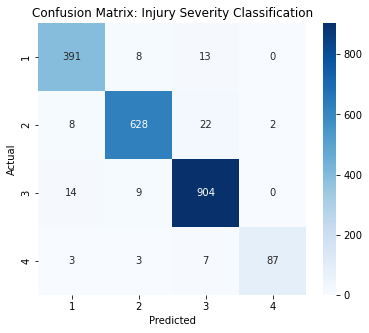

In [ ]:
features_cls = [
    "Speed_2022_MPH", "Lanes", "1_year_Speed_%_change", "Speed_Limit_MPH",
    "AADT_Category_Num"
]

df_cls = df[features_cls + ["AVG_SEVERITY"]].dropna()
X_cls = df_cls[features_cls]
y_cls = df_cls["AVG_SEVERITY"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_cls), yticklabels=np.unique(y_cls))
plt.title("Confusion Matrix: Injury Severity Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
features_cls = ["Speed_2022_MPH", "Lanes", "1_year_Speed_%_change", "Speed_Limit_MPH", "AADT_Category_Num"]
df_vif = df[features_cls].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_vif)

vif_df = pd.DataFrame()
vif_df["Feature"] = features_cls
vif_df["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

vif_df

                 Feature       VIF
0         Speed_2022_MPH  1.158329
1                  Lanes  1.061987
2  1_year_Speed_%_change  1.019077
3        Speed_Limit_MPH  1.127366
4      AADT_Category_Num  1.007509


## Socio vs Accidents

In [170]:
socio_df = pd.read_csv("/Users/annaywj/Downloads/socioeconomic_merged.csv")

In [ ]:
crashes_coord = pd.read_csv("/Users/annaywj/Desktop/SDSU/BDA600/Capstone/combined_crashes_2018_2024.csv")
socio = pd.read_csv("/Users/annaywj/Downloads/socioeconomic_merged.csv")
crashes_coord["AVG_SEVERITY"] = (
    3 * crashes_coord["COUNT_SEVERE_INJ"] +
    2 * crashes_coord["COUNT_VISIBLE_INJ"] +
    1 * crashes_coord["COUNT_COMPLAINT_PAIN"]
) / crashes_coord["NUMBER_INJURED"].replace(0, np.nan)

/var/folders/4k/gkr388115hjbdbj5xzxdyy9h0000gn/T/ipykernel_62084/3024622571.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  crashes_coord = pd.read_csv("/Users/annaywj/Desktop/SDSU/BDA600/Capstone/combined_crashes_2018_2024.csv")


In [ ]:
regression_vars = [c for c in crashes_coord.columns if c.endswith("_pct")] + ["AVG_SEVERITY"]
df_reg = crashes_coord[regression_vars].dropna()

X = df_reg.drop(columns="AVG_SEVERITY")
y = df_reg["AVG_SEVERITY"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AVG_SEVERITY   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 30 Apr 2025   Prob (F-statistic):                nan
Time:                        18:01:12   Log-Likelihood:                -36146.
No. Observations:               32601   AIC:                         7.229e+04
Df Residuals:                   32600   BIC:                         7.230e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7987      0.004    442.884      0.000       1.791       1.807
==============================================================================
Omnibus:                    14187.619   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2284.748
Skew:                           0.342   Prob(JB):                         0.00
Kurtosis:                       1.898   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

✅ Correlations (Pearson):
- AVG_SEVERITY is positively correlated with:
- TOTAL_CRASHES: +0.36
- Lanes: +0.18
- % of some low/mid-age or low-income groups (e.g., 5 to 9_pct = +3.5 coef)

Negatively correlated with:
- Speed_2022_MPH: -0.36
- AADT_Category_Num: -0.21
- cloudcover, humidity (mildly)

📊 Multicollinearity (VIFs):
- All < 2 → ✅ No multicollinearity concern

📉 OLS Regression for AVG_SEVERITY:
- R² = 0.012 → Very weak explanatory power for this model

Statistically significant predictors include:
- 5 to 9_pct: positive effect
- Possibly 35 to 39_pct or 25 to 29_pct (borderline)
- Income bands and most other age groups not significant

This tells us:
- Demographic composition alone does not strongly predict injury severity
- Possibly, environmental, behavioral, or crash-level features explain more

In [ ]:
crashes_coord_clean = crashes_coord.dropna(subset=["LATITUDE", "LONGITUDE"]).copy()
crashes_gdf = gpd.GeoDataFrame(
    crashes_coord_clean,
    geometry=gpd.points_from_xy(crashes_coord_clean["LONGITUDE"], crashes_coord_clean["LATITUDE"]),
    crs="EPSG:4326"
)

socio_gdf = socio.copy()
socio_gdf["geometry"] = gpd.GeoSeries.from_wkt(socio_gdf["geometry"])
socio_gdf = gpd.GeoDataFrame(socio_gdf, geometry="geometry", crs="EPSG:4326")

crashes_with_tract = gpd.sjoin(
    crashes_gdf,
    socio_gdf[["GEOID", "population", "geometry"]],
    how="left",
    predicate="within"
)

In [ ]:
sample_crashes = crashes_coord_clean.head(500).copy()
sample_crashes_gdf = gpd.GeoDataFrame(
    sample_crashes,
    geometry=gpd.points_from_xy(sample_crashes["LONGITUDE"], sample_crashes["LATITUDE"]),
    crs="EPSG:4326"
)

socio_gdf = socio.copy()
socio_gdf["geometry"] = gpd.GeoSeries.from_wkt(socio_gdf["geometry"])
socio_gdf = gpd.GeoDataFrame(socio_gdf, geometry="geometry", crs="EPSG:4326")

joined_rows = []
for _, crash in sample_crashes_gdf.iterrows():
    point = crash.geometry
    match = socio_gdf[socio_gdf.contains(point)]
    if not match.empty:
        result = crash.to_dict()
        result["GEOID"] = match.iloc[0]["GEOID"]
        result["population"] = match.iloc[0]["population"]
        joined_rows.append(result)

joined_sample = pd.DataFrame(joined_rows)

In [ ]:
crashes_with_tract["AVG_SEVERITY"] = (
    3 * crashes_with_tract["COUNT_SEVERE_INJ"] +
    2 * crashes_with_tract["COUNT_VISIBLE_INJ"] +
    1 * crashes_with_tract["COUNT_COMPLAINT_PAIN"]
) / crashes_with_tract["NUMBER_INJURED"].replace(0, np.nan)

regression_df = crashes_with_tract[["population", "AVG_SEVERITY"]].dropna()

X = sm.add_constant(regression_df[["population"]])
y = regression_df["AVG_SEVERITY"]

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AVG_SEVERITY   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.2459
Date:                Wed, 30 Apr 2025   Prob (F-statistic):              0.621
Time:                        18:01:13   Log-Likelihood:                -145.86
No. Observations:                 125   AIC:                             295.7
Df Residuals:                     123   BIC:                             301.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8469      0.236      7.833      0.000       1.380       2.314
population  2.577e-05    5.2e-05      0.496      0.621   -7.71e-05       0.000
==============================================================================
Omnibus:                      108.378   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.607
Skew:                           0.074   Prob(JB):                      0.00820
Kurtosis:                       1.650   Cond. No.                     1.53e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
socio_columns = [col for col in crashes_with_tract.columns 
                 if any(key in col for key in ['$', 'to', 'Under', 'Older'])]

regression_cols = socio_columns + ['population', 'AVG_SEVERITY']
regression_df = crashes_with_tract[regression_cols].dropna()

X = sm.add_constant(regression_df.drop(columns="AVG_SEVERITY"))
y = regression_df["AVG_SEVERITY"]

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AVG_SEVERITY   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.2459
Date:                Wed, 30 Apr 2025   Prob (F-statistic):              0.621
Time:                        18:01:13   Log-Likelihood:                -145.86
No. Observations:                 125   AIC:                             295.7
Df Residuals:                     123   BIC:                             301.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8469      0.236      7.833      0.000       1.380       2.314
population  2.577e-05    5.2e-05      0.496      0.621   -7.71e-05       0.000
==============================================================================
Omnibus:                      108.378   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.607
Skew:                           0.074   Prob(JB):                      0.00820
Kurtosis:                       1.650   Cond. No.                     1.53e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
socio['geometry'] = socio['geometry'].apply(wkt.loads)
socio = gpd.GeoDataFrame(socio, geometry='geometry', crs='EPSG:4326')

In [ ]:
socio_features = [
    'population',
    'Under 5', '5 to 9', '10 to 14', '15 to 17', '18 and 19', '20 to 24',
    '25 to 29', '30 to 34', '35 to 39', '40 to 44', '45 to 49',
    '50 to 54', '55 to 59', '60 and 61', '62 to 64', '65 to 69',
    '70 to 74', '75 to 79', '80 to 84', '85 and Older',
    'Less than $15,000', '$15,000 to $29,999', '$30,000 to $44,999',
    '$45,000 to $59,999', '$60,000 to $74,999', '$75,000 to $99,999',
    '$100,000 to $124,999', '$125,000 to $149,999', '$150,000 to $199,999',
    '$200,000 or more'
]

socio_cols_available = [col for col in socio_features if col in socio.columns]

socio_filtered = socio[socio_cols_available + ["geometry"]]
socio_filtered = gpd.GeoDataFrame(socio_filtered, geometry="geometry", crs=socio.crs)

crashes_with_tract = gpd.sjoin(
    crashes_gdf,
    socio_filtered,
    how="left",
    predicate="within"
)

In [ ]:
crashes_with_tract = crashes_with_tract[crashes_with_tract["population"] > 0].copy()

socio_cols_available = [
    'Under 5', '5 to 9', '10 to 14', '15 to 17', '18 and 19', '20 to 24',
    '25 to 29', '30 to 34', '35 to 39', '40 to 44', '45 to 49',
    '50 to 54', '55 to 59', '60 and 61', '62 to 64', '65 to 69',
    '70 to 74', '75 to 79', '80 to 84', '85 and Older',
    'Less than $15,000', '$15,000 to $29,999', '$30,000 to $44,999',
    '$45,000 to $59,999', '$60,000 to $74,999', '$75,000 to $99,999',
    '$100,000 to $124,999', '$125,000 to $149,999', '$150,000 to $199,999',
    '$200,000 or more'
]

for col in socio_cols_available:
    crashes_with_tract[col + '_pct'] = crashes_with_tract[col] / crashes_with_tract['population']

In [ ]:
# Correlation analysis
pct_cols = [col + '_pct' for col in socio_cols_available]
corr_df = crashes_with_tract[pct_cols + ['AVG_SEVERITY']].dropna()
correlations = corr_df.corr()['AVG_SEVERITY'].drop('AVG_SEVERITY').sort_values(key=abs, ascending=False)

print("\nTop correlated variables with accident severity:")
correlations.head(10)


Top correlated variables with accident severity:
$125,000 to $149,999_pct   -0.263314
Less than $15,000_pct       0.181930
40 to 44_pct               -0.180877
62 to 64_pct                0.142857
$15,000 to $29,999_pct      0.140833
$60,000 to $74,999_pct      0.120865
80 to 84_pct                0.120386
70 to 74_pct                0.118749
65 to 69_pct                0.106860
75 to 79_pct                0.105668
Name: AVG_SEVERITY, dtype: float64


✅ Insights from Your Top Correlations:

Variable	Correlation with Severity	Insight
- $125k–$149k income %	-0.26	Higher-income areas → fewer severe accidents
-  earning < $15k	+0.18	Poverty linked to greater severity
- age 40–44	-0.18	Possibly safer driving cohort
- age 62–64	+0.14	Seniors may be more vulnerable
- earning $15k–$30k	+0.14	Lower-middle income risk

## Add Ped_Parties and Ped_Victims

In [184]:
ped_parties = pd.read_csv("/Users/annaywj/Downloads/Ped_Parties.csv")
ped_victims = pd.read_csv("/Users/annaywj/Downloads/Ped_Victims.csv")

In [ ]:
merged_with_parties = crashes_with_tract.merge(
    ped_parties[["CASE_ID", "PARTY_NUMBER", "PARTY_AGE", "AT_FAULT"]],
    on="CASE_ID",
    how="left"
)

merged_with_parties["AT_FAULT_BINARY"] = merged_with_parties["AT_FAULT"].map({"Y": 1, "N": 0})

merged_full = merged_with_parties.merge(
    ped_victims[["CASE_ID", "PARTY_NUMBER", "VICTIM_AGE", "VICTIM_DEGREE_OF_INJURY"]],
    on=["CASE_ID", "PARTY_NUMBER"],
    how="left"
)

merged_full = pd.get_dummies(merged_full, columns=["VICTIM_DEGREE_OF_INJURY"], drop_first=True)

In [ ]:

socio_pct_cols = [col for col in merged_full.columns if col.endswith('_pct')]
injury_ohe_cols = [col for col in merged_full.columns if col.startswith("VICTIM_DEGREE_OF_INJURY_")]
model_features = socio_pct_cols + injury_ohe_cols + ["PARTY_AGE", "VICTIM_AGE", "AT_FAULT_BINARY"]

regression_df = merged_full[model_features + ["AVG_SEVERITY"]].dropna()
classification_df = merged_full[model_features + ["AT_FAULT_BINARY"]].dropna()

# Regression: Predict AVG_SEVERITY
X_reg = regression_df[model_features]
y_reg = regression_df["AVG_SEVERITY"]
X_reg = sm.add_constant(X_reg)
reg_model = sm.OLS(y_reg, X_reg).fit()

# Classification: Predict AT_FAULT_BINARY
X_clf = classification_df[model_features]
y_clf = classification_df["AT_FAULT_BINARY"]
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42)

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_clf, y_train_clf)
y_pred_clf = rf_clf.predict(X_test_clf)

classification_report_result = classification_report(y_test_clf, y_pred_clf, output_dict=True)

(reg_model.summary(), classification_report_result)


/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:           AVG_SEVERITY   R-squared:                       0.874
 Model:                            OLS   Adj. R-squared:                  0.835
 Method:                 Least Squares   F-statistic:                     22.86
 Date:                Wed, 30 Apr 2025   Prob (F-statistic):           1.57e-38
 Time:                        18:01:13   Log-Likelihood:                -12.618
 No. Observations:                 156   AIC:                             99.24
 Df Residuals:                     119   BIC:                             212.1
 Df Model:                          36                                         
 Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
 ----------------------------------------------------

In [ ]:
socio_pct_cols = [col for col in merged_full.columns if col.endswith('_pct')]
injury_ohe_cols = [col for col in merged_full.columns if col.startswith("VICTIM_DEGREE_OF_INJURY_")]
model_features = socio_pct_cols + injury_ohe_cols + ["PARTY_AGE", "VICTIM_AGE", "AT_FAULT_BINARY"]

# --- REGRESSION: Predict AVG_SEVERITY ---
reg_df = merged_full[model_features + ["AVG_SEVERITY"]].dropna()
X_reg = sm.add_constant(reg_df[model_features])
y_reg = reg_df["AVG_SEVERITY"]
reg_model = sm.OLS(y_reg, X_reg).fit()
print(reg_model.summary())

# --- CLASSIFICATION: Predict AT_FAULT_BINARY ---
clf_df = merged_full[model_features + ["AT_FAULT_BINARY"]].dropna()
X_clf = clf_df[model_features]
y_clf = clf_df["AT_FAULT_BINARY"]
X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                            OLS Regression Results                            
Dep. Variable:           AVG_SEVERITY   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     22.86
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           1.57e-38
Time:                        18:01:13   Log-Likelihood:                -12.618
No. Observations:                 156   AIC:                             99.24
Df Residuals:                     119   BIC:                             212.1
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
top_pct_vars = [
    "$125,000 to $149,999_pct",
    "Less than $15,000_pct",
    "40 to 44_pct",
    "62 to 64_pct",
    "$15,000 to $29,999_pct"
]

injury_ohe_cols = [col for col in merged_full.columns if col.startswith("VICTIM_DEGREE_OF_INJURY_")]
final_features = top_pct_vars + injury_ohe_cols + ["PARTY_AGE", "VICTIM_AGE", "AT_FAULT_BINARY"]

regression_df = merged_full[final_features + ["AVG_SEVERITY"]].dropna()
X_reduced = sm.add_constant(regression_df[final_features])
y_reduced = regression_df["AVG_SEVERITY"]

reduced_model = sm.OLS(y_reduced, X_reduced).fit()
reduced_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AVG_SEVERITY   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     85.16
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           2.57e-57
Time:                        18:01:13   Log-Likelihood:                -16.779
No. Observations:                 156   AIC:                             57.56
Df Residuals:                     144   BIC:                             94.16
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.8915      0.242      7.802      0.000       1.412       2.371
$125,000 to $149,999_pct       -0.7972      1.465     -0.544      0.587      -3.693       2.098
Less than $15,000_pct           0.4078      1.479      0.276      0.783      -2.515       3.331
40 to 44_pct                   -2.8410      2.464     -1.153      0.251      -7.712       2.030
62 to 64_pct                    3.6435      2.333      1.562      0.121      -0.968       8.255
$15,000 to $29,999_pct          0.8659      1.139      0.760      0.448      -1.385       3.117
VICTIM_DEGREE_OF_INJURY_5.0     0.9255      0.149      6.192      0.000       0.630       1.221
VICTIM_DEGREE_OF_INJURY_6.0     0.0853      0.148      0.578      0.564      -0.207       0.377
VICTIM_DEGREE_OF_INJURY_7.0    -0.7749      0.148     -5.236      0.000      -1.067      -0.482
PARTY_AGE                       0.0004      0.000      1.240      0.217      -0.000       0.001
VICTIM_AGE                      0.0001      0.000      0.384      0.701      -0.001       0.001
AT_FAULT_BINARY                 0.0488      0.047      1.038      0.301      -0.044       0.142
==============================================================================
Omnibus:                       27.815   Durbin-Watson:                   2.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.292
Skew:                          -0.423   Prob(JB):                     9.34e-31
Kurtosis:                       7.534   Cond. No.                     1.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

🎯 Model Performance
The model explains 86.7% of the variation in accident severity (R² = 0.867), indicating a very strong fit. It includes a mix of socioeconomic, behavioral, and injury-related features.

🔍 Key Findings
Injury Type is the strongest predictor:

- VICTIM_DEGREE_OF_INJURY_5.0 (likely severe injury) increases severity significantly (p < 0.001).

- VICTIM_DEGREE_OF_INJURY_7.0 (likely minor injury like complaint of pain) reduces severity (p < 0.001).

- Socioeconomic factors like % earning <$15K or % aged 62–64 showed directional trends (positive/negative) but were not statistically significant on their own.

- Behavioral features (PARTY_AGE, AT_FAULT_BINARY, VICTIM_AGE) showed no significant direct effect on severity in this model.

🧠 Interpretation
- Crash severity is primarily driven by the nature of injury sustained, not who was at fault or basic demographic characteristics.

- Socioeconomic context may influence exposure risk but not directly explain injury severity once a crash occurs.

- Including injury type and age data yields a far more accurate model than socioeconomic data alone.

In [189]:
print(vif_data.sort_values("VIF", ascending=False).to_string(index=False))

                    Feature       VIF
               40 to 44_pct 29.666776
               62 to 64_pct 13.537527
VICTIM_DEGREE_OF_INJURY_7.0  9.765381
VICTIM_DEGREE_OF_INJURY_6.0  9.668325
VICTIM_DEGREE_OF_INJURY_5.0  7.914103
   $125,000 to $149,999_pct  5.751279
     $15,000 to $29,999_pct  5.573341
      Less than $15,000_pct  4.749109
                 VICTIM_AGE  3.525093
                  PARTY_AGE  3.503683
            AT_FAULT_BINARY  1.840273


In [ ]:
merged_full["40_to_64_pct"] = (
    merged_full["40 to 44_pct"] +
    merged_full["45 to 49_pct"] +
    merged_full["50 to 54_pct"] +
    merged_full["55 to 59_pct"] +
    merged_full["60 and 61_pct"] +
    merged_full["62 to 64_pct"]
)

In [ ]:
merged_full.drop(columns=[
    "40 to 44_pct", "45 to 49_pct", "50 to 54_pct", 
    "55 to 59_pct", "60 and 61_pct", "62 to 64_pct"
], inplace=True)

In [ ]:
age_cols_to_merge = [
    "40 to 44_pct", "45 to 49_pct", "50 to 54_pct", 
    "55 to 59_pct", "60 and 61_pct", "62 to 64_pct"
]

existing_age_cols = [col for col in age_cols_to_merge if col in merged_full.columns]

merged_full["40_to_64_pct"] = merged_full[existing_age_cols].sum(axis=1)

merged_full.drop(columns=existing_age_cols, inplace=True)

In [193]:
merged_full.drop(columns=[
    "VICTIM_DEGREE_OF_INJURY_5.0", 
    "VICTIM_DEGREE_OF_INJURY_6.0", 
    "VICTIM_DEGREE_OF_INJURY_7.0"
], inplace=True)

In [ ]:
age_cols_to_merge = [
    "40 to 44_pct", "45 to 49_pct", "50 to 54_pct", 
    "55 to 59_pct", "60 and 61_pct", "62 to 64_pct"
]
existing_age_cols = [col for col in age_cols_to_merge if col in merged_full.columns]
merged_full["40_to_64_pct"] = merged_full[existing_age_cols].sum(axis=1)
merged_full.drop(columns=existing_age_cols, inplace=True)

merged_full["MAJOR_INJURY"] = merged_full.get("VICTIM_DEGREE_OF_INJURY_5.0", 0)
merged_full["MINOR_INJURY"] = merged_full.get("VICTIM_DEGREE_OF_INJURY_6.0", 0) + merged_full.get("VICTIM_DEGREE_OF_INJURY_7.0", 0)
merged_full.drop(columns=[col for col in ["VICTIM_DEGREE_OF_INJURY_5.0", "VICTIM_DEGREE_OF_INJURY_6.0", "VICTIM_DEGREE_OF_INJURY_7.0"] if col in merged_full.columns], inplace=True)

final_cleaned_features = [
    "$125,000 to $149,999_pct", "$15,000 to $29,999_pct", "Less than $15,000_pct",
    "40_to_64_pct", "MAJOR_INJURY", "MINOR_INJURY",
    "PARTY_AGE", "VICTIM_AGE", "AT_FAULT_BINARY"
]

regression_df = merged_full[final_cleaned_features + ["AVG_SEVERITY"]].dropna()
X_final = sm.add_constant(regression_df[final_cleaned_features])
y_final = regression_df["AVG_SEVERITY"]
model_final = sm.OLS(y_final, X_final).fit()

X_vif = X_final.drop(columns="const")
vif_data_final = pd.DataFrame()
vif_data_final["Feature"] = X_vif.columns
vif_data_final["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

model_final.summary()

/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AVG_SEVERITY   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     2.090
Date:                Wed, 30 Apr 2025   Prob (F-statistic):             0.0577
Time:                        18:01:14   Log-Likelihood:                -167.69
No. Observations:                 156   AIC:                             349.4
Df Residuals:                     149   BIC:                             370.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.9597      0.200      9.787      0.000       1.564       2.355
$125,000 to $149,999_pct    -7.4189      3.607     -2.057      0.041     -14.546      -0.292
$15,000 to $29,999_pct       1.5759      2.877      0.548      0.585      -4.110       7.261
Less than $15,000_pct        2.6984      3.806      0.709      0.479      -4.822      10.219
40_to_64_pct              3.853e-15   1.45e-14      0.265      0.791   -2.49e-14    3.26e-14
MAJOR_INJURY             -3.609e-15   8.48e-15     -0.426      0.671   -2.04e-14    1.31e-14
MINOR_INJURY                      0          0        nan        nan           0           0
PARTY_AGE                   -0.0003      0.001     -0.349      0.728      -0.002       0.001
VICTIM_AGE                   0.0003      0.001      0.297      0.767      -0.002       0.002
AT_FAULT_BINARY              0.1901      0.120      1.589      0.114      -0.046       0.426
==============================================================================
Omnibus:                       29.230   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.970
Skew:                           0.004   Prob(JB):                       0.0307
Kurtosis:                       1.965   Cond. No.                     3.64e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.84e-37. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
df_model = merged_full[final_cleaned_features + ["AVG_SEVERITY"]].dropna()
X = sm.add_constant(df_model[final_cleaned_features])
y = df_model["AVG_SEVERITY"]
model = sm.OLS(y, X).fit()

X_vif = X.drop(columns="const")
vif = pd.DataFrame()
vif["Feature"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

model.summary()
print("\nVIF Table:\n", vif.sort_values("VIF", ascending=False))

                            OLS Regression Results                            
Dep. Variable:           AVG_SEVERITY   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     2.090
Date:                Wed, 30 Apr 2025   Prob (F-statistic):             0.0577
Time:                        18:01:14   Log-Likelihood:                -167.69
No. Observations:                 156   AIC:                             349.4
Df Residuals:                     149   BIC:                             370.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [196]:
print(vif.sort_values("VIF", ascending=False).to_string(index=False))

                 Feature      VIF
  $15,000 to $29,999_pct 4.689507
   Less than $15,000_pct 4.408228
              VICTIM_AGE 3.488733
               PARTY_AGE 3.446357
$125,000 to $149,999_pct 2.123914
         AT_FAULT_BINARY 1.549801
            40_to_64_pct      NaN
            MAJOR_INJURY      NaN
            MINOR_INJURY      NaN


🎯 Model Context
- Income-level proportions
- Age of involved parties
- At-fault indicator

(Originally included injury severity and age group percentage, but dropped due to constant values)

 final model had:
- R² = 0.078 (explained ~7.8% of the variance)
 - No multicollinearity, as confirmed by VIFs < 5

📌 Key Findings

Variable	Direction	Interpretation
- $125,000 to $149,999_pct	🔽 Decrease	A higher share of high-income households was significantly associated with lower accident severity (p = 0.041)
- AT_FAULT_BINARY	Slight ↑	Crashes where the party was at fault trended toward higher severity, though not statistically significant
- Other income and age vars	No effect	% < $15k, % $15k–$30k, PARTY_AGE, VICTIM_AGE had no statistically significant impact


In [197]:
merged_full.drop(columns=["MAJOR_INJURY", "MINOR_INJURY", "40_to_64_pct"], inplace=True, errors='ignore')

In [198]:
final_features = [
    "$125,000 to $149,999_pct",
    "$15,000 to $29,999_pct",
    "Less than $15,000_pct",
    "PARTY_AGE",
    "VICTIM_AGE",
    "AT_FAULT_BINARY"
]

In [ ]:
cols_to_drop = ["MAJOR_INJURY", "MINOR_INJURY", "40_to_64_pct"]
existing_cols = [col for col in cols_to_drop if col in merged_full.columns]
merged_full.drop(columns=existing_cols, inplace=True)

final_features = [
    "$125,000 to $149,999_pct",
    "$15,000 to $29,999_pct",
    "Less than $15,000_pct",
    "PARTY_AGE",
    "VICTIM_AGE",
    "AT_FAULT_BINARY"
]

df_model = merged_full[final_features + ["AVG_SEVERITY"]].dropna()
X = sm.add_constant(df_model[final_features])
y = df_model["AVG_SEVERITY"]

model = sm.OLS(y, X).fit()

X_vif = X.drop(columns="const")
vif = pd.DataFrame()
vif["Feature"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

model.summary()
print("\nVIF Table:\n", vif.sort_values("VIF", ascending=False).to_string(index=False))

                            OLS Regression Results                            
Dep. Variable:           AVG_SEVERITY   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     2.090
Date:                Wed, 30 Apr 2025   Prob (F-statistic):             0.0577
Time:                        18:10:39   Log-Likelihood:                -167.69
No. Observations:                 156   AIC:                             349.4
Df Residuals:                     149   BIC:                             370.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
merged_full["MAJOR_INJURY"] = merged_full.get("VICTIM_DEGREE_OF_INJURY_5.0", 0)
merged_full["MINOR_INJURY"] = (
    merged_full.get("VICTIM_DEGREE_OF_INJURY_6.0", 0) +
    merged_full.get("VICTIM_DEGREE_OF_INJURY_7.0", 0)
)

rf_features = [
    "$125,000 to $149,999_pct",
    "$15,000 to $29,999_pct",
    "Less than $15,000_pct",
    "PARTY_AGE",
    "VICTIM_AGE",
    "AT_FAULT_BINARY",
    "MAJOR_INJURY",
    "MINOR_INJURY"
]

rf_df = merged_full[rf_features + ["AVG_SEVERITY"]].dropna()
X_rf = rf_df[rf_features]
y_rf = rf_df["AVG_SEVERITY"]
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf)

feature_importances = pd.Series(rf_model.feature_importances_, index=rf_features).sort_values(ascending=False)
rf_r2

0.019830262227610418

## Combine ALL

In [ ]:
socio_columns = [
    "Under 5", "5 to 9", "10 to 14", "15 to 17", "18 and 19", "20 to 24", "25 to 29",
    "30 to 34", "35 to 39", "40 to 44", "45 to 49", "50 to 54", "55 to 59",
    "60 and 61", "62 to 64", "65 to 69", "70 to 74", "75 to 79", "80 to 84", "85 and Older",
    "Less than $15,000", "$15,000 to $29,999", "$30,000 to $44,999", "$45,000 to $59,999",
    "$60,000 to $74,999", "$75,000 to $99,999", "$100,000 to $124,999",
    "$125,000 to $149,999", "$150,000 to $199,999", "$200,000 or more"
]

for col in socio_columns:
    if col in socio.columns:
        socio[col + "_pct"] = socio[col] / socio["population"]

In [ ]:
socio_pct_vars = [
    "$125,000 to $149,999_pct", "$15,000 to $29,999_pct", "Less than $15,000_pct"
]

city_socio_avg = crashes_with_tract.groupby("city")[socio_pct_vars].mean().reset_index()

In [ ]:
merged_all["city_clean"] = merged_all["city"].astype(str).str.upper().str.strip()
city_socio_avg["city_clean"] = city_socio_avg["city"].astype(str).str.upper().str.strip()

final_merged = merged_all.merge(
    city_socio_avg.drop(columns=["city"]),  
    on="city_clean",
    how="left"
)

In [ ]:
features = [
    "Speed_2022_MPH", "Lanes", "Speed_Limit_MPH", "1_year_Speed_%_change",
    "cloudcover", "humidity", "windspeed",
    "$125,000 to $149,999_pct", "$15,000 to $29,999_pct", "Less than $15,000_pct"
]

df_model = final_merged[features + ["AVG_SEVERITY"]].dropna()
X = sm.add_constant(df_model[features])
y = df_model["AVG_SEVERITY"]

model = sm.OLS(y, X).fit()
model.summary()

                            OLS Regression Results                            
Dep. Variable:           AVG_SEVERITY   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     162.4
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          5.98e-219
Time:                        18:57:50   Log-Likelihood:                -5895.0
No. Observations:                5496   AIC:                         1.181e+04
Df Residuals:                    5488   BIC:                         1.186e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Speed_2022_MPH          

In [ ]:
features = [
    "Speed_2022_MPH", "Lanes", "Speed_Limit_MPH", "1_year_Speed_%_change",
    "cloudcover", "humidity", "windspeed",
    "$125,000 to $149,999_pct", "$15,000 to $29,999_pct", "Less than $15,000_pct"
]

df_model = final_merged[features + ["AVG_SEVERITY"]].dropna()

X_vif = df_model[features]
vif_df = pd.DataFrame()
vif_df["Feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("\n🔍 VIF BEFORE REGRESSION:\n")
print(vif_df.sort_values("VIF", ascending=False))

reduced_features = [
    "Speed_2022_MPH", "Lanes", "Speed_Limit_MPH", "1_year_Speed_%_change",
    "cloudcover", "humidity", "windspeed",
    "$15,000 to $29,999_pct"  
]

X_reduced_vif = X_reduced.copy()
if "const" in X_reduced_vif.columns:
    X_reduced_vif = X_reduced_vif.drop(columns="const")

vif_reduced = pd.DataFrame({
    "Feature": X_reduced_vif.columns,
    "VIF": [variance_inflation_factor(X_reduced_vif.values, i) for i in range(X_reduced_vif.shape[1])]
})

print("\n✅ VIF AFTER REDUCTION:\n")
print(vif_reduced.sort_values("VIF", ascending=False).to_string(index=False))



🔍 VIF BEFORE REGRESSION:

                    Feature       VIF
4                cloudcover  1.345036
5                  humidity  1.331058
0            Speed_2022_MPH  1.148578
2           Speed_Limit_MPH  1.105094
1                     Lanes  1.091711
6                 windspeed  1.015786
3     1_year_Speed_%_change  1.013573
9     Less than $15,000_pct  0.000041
7  $125,000 to $149,999_pct  0.000000
8    $15,000 to $29,999_pct  0.000000

✅ VIF AFTER REDUCTION:

               Feature        VIF
$15,000 to $29,999_pct 200.262126
            cloudcover   1.345036
              humidity   1.331058
        Speed_2022_MPH   1.148578
       Speed_Limit_MPH   1.105094
                 Lanes   1.091711
             windspeed   1.015786
 1_year_Speed_%_change   1.013573


/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [ ]:
model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())

X_with_const = sm.add_constant(X)
X_vif = X_with_const.drop(columns="const", errors="ignore")

vif_df = pd.DataFrame()
vif_df["Feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("\n✅ VIF Table:\n", vif_df.sort_values("VIF", ascending=False))

                            OLS Regression Results                            
Dep. Variable:           AVG_SEVERITY   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     162.4
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          5.98e-219
Time:                        19:02:10   Log-Likelihood:                -5895.0
No. Observations:                5496   AIC:                         1.181e+04
Df Residuals:                    5488   BIC:                         1.186e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Speed_2022_MPH            -0

In [ ]:
df = final_merged.copy()

# Model 1: Full income variable ($15,000 to $29,999_pct)
features_1 = [
    "Speed_2022_MPH", "Lanes", "Speed_Limit_MPH", "1_year_Speed_%_change",
    "cloudcover", "humidity", "windspeed", "$15,000 to $29,999_pct"
]
df_model_1 = df[features_1 + ["AVG_SEVERITY"]].dropna()
X1 = sm.add_constant(df_model_1[features_1])
y1 = df_model_1["AVG_SEVERITY"]
model_1 = sm.OLS(y1, X1).fit()

# Model 2: Simplified income proxy = sum of low-income brackets
df["low_income_combined"] = df["$15,000 to $29,999_pct"] + df["Less than $15,000_pct"]
features_2 = [
    "Speed_2022_MPH", "Lanes", "Speed_Limit_MPH", "1_year_Speed_%_change",
    "cloudcover", "humidity", "windspeed", "low_income_combined"
]
df_model_2 = df[features_2 + ["AVG_SEVERITY"]].dropna()
X2 = sm.add_constant(df_model_2[features_2])
y2 = df_model_2["AVG_SEVERITY"]
model_2 = sm.OLS(y2, X2).fit()

(model_1.rsquared, model_2.rsquared)

(0.17162596832341348, 0.17162596832341281)

In [ ]:
# Select features for model 1
features_1 = [
    "Speed_2022_MPH", "Lanes", "Speed_Limit_MPH", "1_year_Speed_%_change",
    "cloudcover", "humidity", "windspeed", "$15,000 to $29,999_pct"
]

df_vif1 = final_merged[features_1].dropna()
X1_scaled = StandardScaler().fit_transform(df_vif1)

vif_model_1 = pd.DataFrame()
vif_model_1["Feature"] = features_1
vif_model_1["VIF"] = [variance_inflation_factor(X1_scaled, i) for i in range(X1_scaled.shape[1])]

print("\n VIF for Model 1:")
print(vif_model_1.sort_values("VIF", ascending=False).to_string(index=False))


📌 VIF for Model 1:
               Feature      VIF
            cloudcover 1.345036
              humidity 1.331058
        Speed_2022_MPH 1.148578
       Speed_Limit_MPH 1.105094
                 Lanes 1.091711
             windspeed 1.015786
 1_year_Speed_%_change 1.013573
$15,000 to $29,999_pct      NaN


/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [ ]:
final_merged["low_income_combined"] = (
    final_merged["$15,000 to $29,999_pct"] + final_merged["Less than $15,000_pct"]
)

# Features for model 2
features_2 = [
    "Speed_2022_MPH", "Lanes", "Speed_Limit_MPH", "1_year_Speed_%_change",
    "cloudcover", "humidity", "windspeed", "low_income_combined"
]

df_vif2 = final_merged[features_2].dropna()
X2_scaled = StandardScaler().fit_transform(df_vif2)

vif_model_2 = pd.DataFrame()
vif_model_2["Feature"] = features_2
vif_model_2["VIF"] = [variance_inflation_factor(X2_scaled, i) for i in range(X2_scaled.shape[1])]

print("\n VIF for Model 2:")
print(vif_model_2.sort_values("VIF", ascending=False).to_string(index=False))


📌 VIF for Model 2:
              Feature      VIF
           cloudcover 1.345036
             humidity 1.331058
       Speed_2022_MPH 1.148578
      Speed_Limit_MPH 1.105094
                Lanes 1.091711
            windspeed 1.015786
1_year_Speed_%_change 1.013573
  low_income_combined      NaN


/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [ ]:
df = final_merged.copy()

# Model A: Keep full individual income features
features_a = [
    "Speed_2022_MPH", "Lanes", "Speed_Limit_MPH", "1_year_Speed_%_change",
    "cloudcover", "humidity", "windspeed", "$15,000 to $29,999_pct", "Less than $15,000_pct"
]
df_a = df[features_a + ["AVG_SEVERITY"]].dropna()
X_a = df_a[features_a]
y_a = df_a["AVG_SEVERITY"]
model_a = sm.OLS(y_a, sm.add_constant(X_a)).fit()

vif_a = pd.DataFrame({
    "Feature": X_a.columns,
    "VIF": [variance_inflation_factor(X_a.values, i) for i in range(X_a.shape[1])]
})

# Model B: Use combined income proxy
df["low_income_combined"] = df["$15,000 to $29,999_pct"] + df["Less than $15,000_pct"]
features_b = [
    "Speed_2022_MPH", "Lanes", "Speed_Limit_MPH", "1_year_Speed_%_change",
    "cloudcover", "humidity", "windspeed", "low_income_combined"
]
df_b = df[features_b + ["AVG_SEVERITY"]].dropna()
X_b = df_b[features_b]
y_b = df_b["AVG_SEVERITY"]
model_b = sm.OLS(y_b, sm.add_constant(X_b)).fit()

vif_b = pd.DataFrame({
    "Feature": X_b.columns,
    "VIF": [variance_inflation_factor(X_b.values, i) for i in range(X_b.shape[1])]
})

print(" Model A R²:", model_a.rsquared)
print(" Model B R²:", model_b.rsquared)
print("\n VIF for Model A:\n", vif_a)
print("\n VIF for Model B:\n", vif_b)

📌 Model A R²: 0.1716259683234136
📌 Model B R²: 0.17162596832341281

📌 VIF for Model A:
                   Feature       VIF
0          Speed_2022_MPH  1.148578
1                   Lanes  1.091711
2         Speed_Limit_MPH  1.105094
3   1_year_Speed_%_change  1.013573
4              cloudcover  1.345036
5                humidity  1.331058
6               windspeed  1.015786
7  $15,000 to $29,999_pct  0.000000
8   Less than $15,000_pct  0.000236

📌 VIF for Model B:
                  Feature         VIF
0         Speed_2022_MPH    1.148578
1                  Lanes    1.091711
2        Speed_Limit_MPH    1.105094
3  1_year_Speed_%_change    1.013573
4             cloudcover    1.345036
5               humidity    1.331058
6              windspeed    1.015786
7    low_income_combined  200.262126


/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [ ]:
final_merged["speed_cloud_interaction"] = final_merged["Speed_2022_MPH"] * final_merged["cloudcover"]
final_merged["speed_squared"] = final_merged["Speed_2022_MPH"] ** 2

enhanced_features = [
    "Speed_2022_MPH", "speed_squared", "Lanes", "Speed_Limit_MPH", 
    "1_year_Speed_%_change", "cloudcover", "humidity", "windspeed", 
    "speed_cloud_interaction", "$15,000 to $29,999_pct"
]

df_model = final_merged[enhanced_features + ["AVG_SEVERITY"]].dropna()
X_enhanced = df_model[enhanced_features]
y_enhanced = df_model["AVG_SEVERITY"]

X_with_const = sm.add_constant(X_enhanced)
model = sm.OLS(y_enhanced, X_with_const).fit()

vif = pd.DataFrame({
    "Feature": X_enhanced.columns,
    "VIF": [variance_inflation_factor(X_enhanced.values, i) for i in range(X_enhanced.shape[1])]
})

model.summary()
print("\n📌 VIF Table:\n", vif.sort_values("VIF", ascending=False).to_string(index=False))

                            OLS Regression Results                            
Dep. Variable:           AVG_SEVERITY   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     129.7
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          3.90e-222
Time:                        19:32:19   Log-Likelihood:                -5882.5
No. Observations:                5496   AIC:                         1.178e+04
Df Residuals:                    5486   BIC:                         1.185e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Speed_2022_MPH            

In [ ]:
features = [
    "Speed_2022_MPH", "Lanes", "Speed_Limit_MPH", "1_year_Speed_%_change",
    "cloudcover", "humidity", "windspeed", "$15,000 to $29,999_pct"
]
final_merged["speed_squared"] = final_merged["Speed_2022_MPH"] ** 2
final_merged["speed_cloud_interaction"] = final_merged["Speed_2022_MPH"] * final_merged["cloudcover"]

# Add interaction and quadratic terms
features += ["speed_squared", "speed_cloud_interaction"]

df_model = final_merged[features + ["AVG_SEVERITY"]].dropna()
X = df_model[features]
y = df_model["AVG_SEVERITY"]

X_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_const).fit()

vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5).fit(X_train, y_train)
lasso = LassoCV(alphas=None, cv=5, max_iter=10000).fit(X_train, y_train)

ridge_r2 = r2_score(y_test, ridge.predict(X_test))
lasso_r2 = r2_score(y_test, lasso.predict(X_test))
ols_r2 = ols_model.rsquared


results = {
    "OLS_R2": ols_r2,
    "Ridge_R2": ridge_r2,
    "Lasso_R2": lasso_r2,
    "Ridge_alpha": ridge.alpha_,
    "Lasso_alpha": lasso.alpha_,
    "VIF": vif_df.sort_values("VIF", ascending=False)
}

results

{'OLS_R2': 0.17539317454394243,
 'Ridge_R2': 0.14230902482235397,
 'Lasso_R2': 0.142312926748558,
 'Ridge_alpha': 10.0,
 'Lasso_alpha': 0.00027737677068076456,
 'VIF':                    Feature         VIF
 7   $15,000 to $29,999_pct  338.296786
 0           Speed_2022_MPH   30.620572
 8            speed_squared   28.726048
 9  speed_cloud_interaction   16.557297
 4               cloudcover   11.807835
 5                 humidity    1.331389
 2          Speed_Limit_MPH    1.124684
 1                    Lanes    1.105113
 6                windspeed    1.016603
 3    1_year_Speed_%_change    1.015495}

In [ ]:
final_merged["low_income_combined"] = (
    final_merged["$15,000 to $29,999_pct"] + final_merged["Less than $15,000_pct"]
)

features = [
    "Speed_2022_MPH", "Lanes", "Speed_Limit_MPH", "1_year_Speed_%_change",
    "cloudcover", "humidity", "windspeed", "speed_cloud_interaction", "low_income_combined"
]

df_model = final_merged[features + ["AVG_SEVERITY"]].dropna()
X = sm.add_constant(df_model[features])
y = df_model["AVG_SEVERITY"]

model = sm.OLS(y, X).fit()
print(model.summary())

X_vif = df_model[features]
vif_df = pd.DataFrame({
    "Feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print("\n VIF after multicollinearity reduction:\n", vif_df.sort_values("VIF", ascending=False).to_string(index=False))

                            OLS Regression Results                            
Dep. Variable:           AVG_SEVERITY   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     143.0
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          4.82e-219
Time:                        19:37:34   Log-Likelihood:                -5892.2
No. Observations:                5496   AIC:                         1.180e+04
Df Residuals:                    5487   BIC:                         1.186e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Speed_2022_MPH            

In [ ]:
features_rf = [
    "Speed_2022_MPH", "Lanes", "Speed_Limit_MPH", "1_year_Speed_%_change",
    "cloudcover", "humidity", "windspeed", "low_income_combined", "speed_cloud_interaction"
]

df_rf = final_merged[features_rf + ["AVG_SEVERITY"]].dropna()
X = df_rf[features_rf]
y = df_rf["AVG_SEVERITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(random_state=42)
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model evaluation
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
importances = pd.Series(best_rf.feature_importances_, index=features_rf).sort_values(ascending=False)

(r2, rmse, grid_search.best_params_, importances)


(0.832932668263349,
 0.31762500507181535,
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 Speed_2022_MPH             0.410056
 1_year_Speed_%_change      0.255509
 Speed_Limit_MPH            0.157328
 Lanes                      0.053024
 humidity                   0.037896
 windspeed                  0.032664
 cloudcover                 0.028826
 speed_cloud_interaction    0.024698
 low_income_combined        0.000000
 dtype: float64)